# Project Preparation 

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import requests
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
from datetime import datetime, timedelta
from itertools import combinations
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")



### Dynamic stock data fetcher

Stock fetcher extracts the current Wikipedia list of all S&P 500 companies


In [2]:

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())


503


### Data wrangling

Exploring the data, preparing it and cleaning it

In [3]:
# Reading data from the given csv file
data = pd.read_csv('SP500_prices.csv')

# Data cleaning - removing columns with company names not in S&P 500
for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering
data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"][data.date < "2022"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

# Print the data
data.head()

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667


Analysis will be conducted on daily returns

In [4]:
returns_1_day = data.pct_change()

# Removing the first row of NaN values due to pct_change functio
returns_1_day = returns_1_day.iloc[1:,:]

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with Missing Values:")
print(columns_with_missing_values)

# Display total number of missing values in each column
print("\nTotal Number of Missing Values in Each Column:")
print(missing_values)

# Print missing vlues in csv file
missing_values.to_csv('missing.csv')

# As we can see, there are columns with missing values, we will drop them
returns_1_day.dropna(axis=1,inplace=True)

Columns with Missing Values:
CARR     556
CDAY      79
CEG     1007
CTVA     350
DOW      304
FOX      299
FOXA     298
MRNA     235
OTIS     556
dtype: int64

Total Number of Missing Values in Each Column:
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 473, dtype: int64


Let us print out two stocks that have historically performed similarly (just by trying out couple pairs)

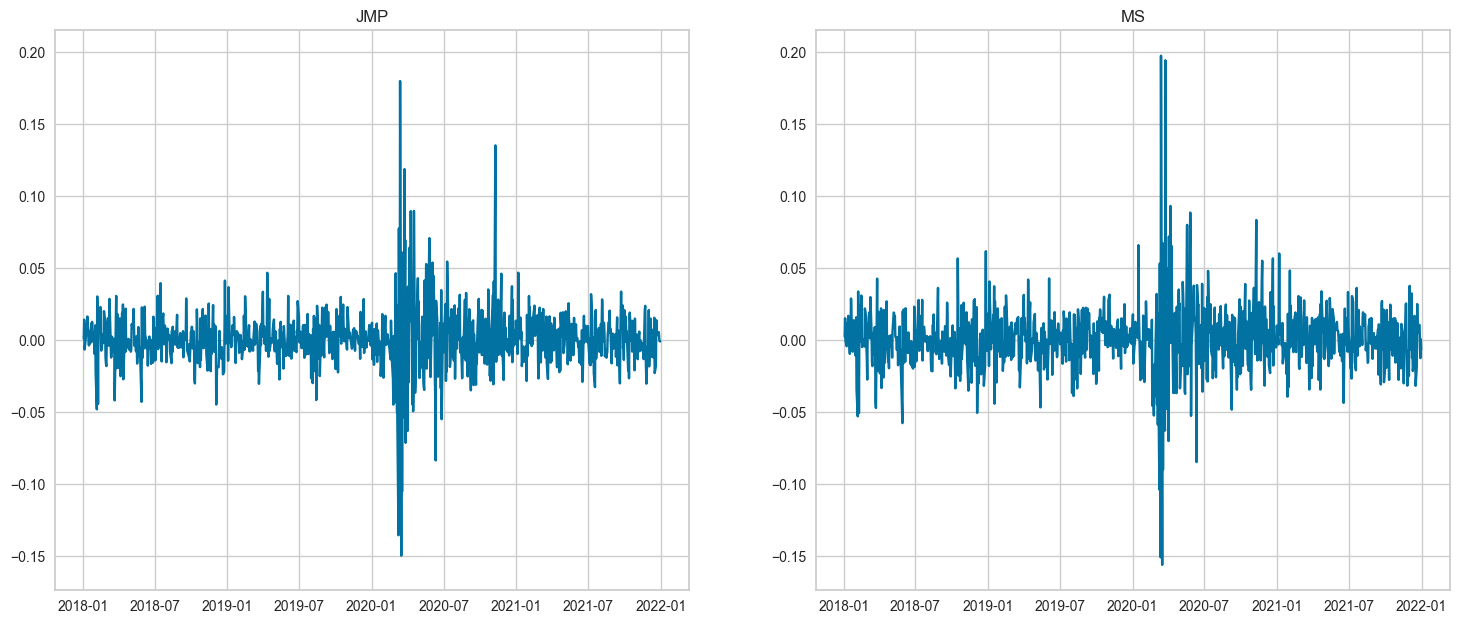

In [5]:
# Chose two well known stocks in the same industry group (JPM and MS both banking sektor)

plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(returns_1_day["JPM"])
plt.title("JMP")

plt.subplot(222, sharey=ax1)
plt.plot(returns_1_day["MS"])
plt.title("MS")
plt.show()

For clustering we need to change our dataframe to be suitable to our algorithms

In [6]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
ret_T.index.name = 'stock'
ret_T.head()

date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
stock,,,,,,,,,,,,,,,,,,,,,
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011653,...,0.004111,-0.006604,0.023534,0.018317,0.006506,0.005957,0.002772,0.009235,0.001432,-0.007646
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.026029,0.020649,0.047399,0.007726,0.000000,-0.004929,0.020363,-0.026429,0.001108,-0.006087
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000114,-0.000230,0.005680,0.010326,-0.005082,0.016516,...,-0.006502,-0.008122,0.019087,0.015319,0.003644,0.022975,-0.005767,0.000502,-0.006578,-0.003535
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007539,-0.005487,0.002930,0.010779,0.021427,0.018246,...,-0.017074,0.010268,-0.006954,0.016160,0.007876,0.009918,-0.000149,0.007218,0.004211,-0.003899
ABT,0.002211,-0.001697,0.002890,-0.002882,0.001700,-0.001527,0.006832,-0.001866,-0.006798,0.009411,...,0.007495,-0.015535,0.002149,0.027500,0.001223,0.016528,-0.006998,0.005125,-0.001346,-0.001844


To optain the right amount of dumentionality reduction without looksing too much variance/information we will use the pareto principal

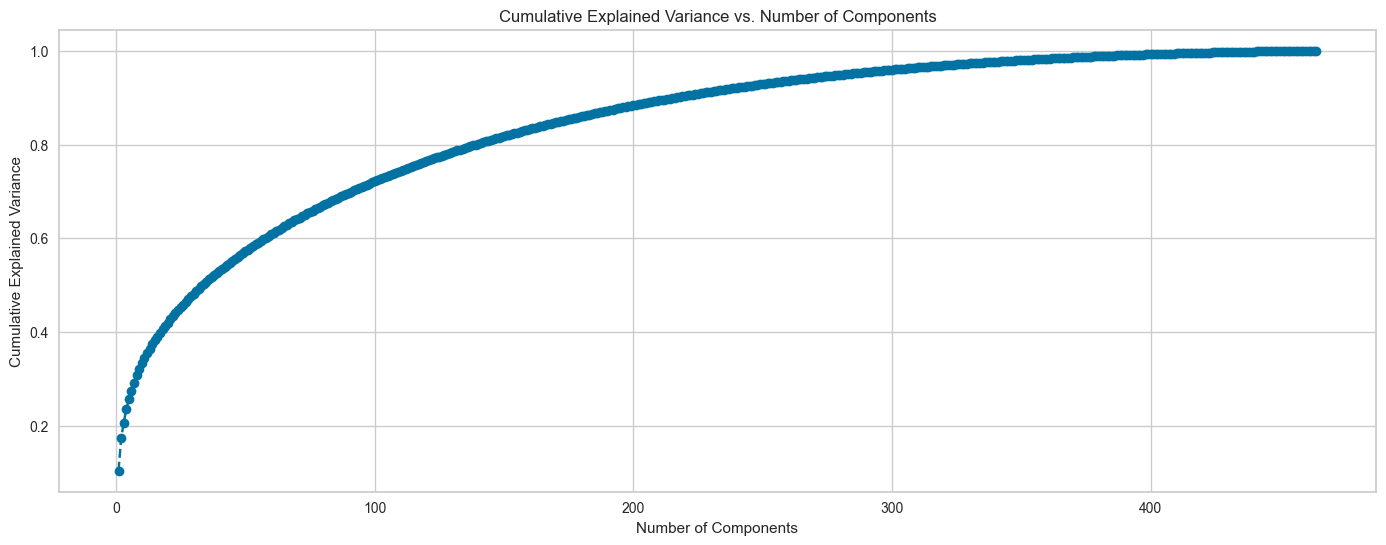

91 components needed to explain 70% of the variance
139 components needed to explain 80% of the variance
216 components needed to explain 90% of the variance


In [7]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA(random_state=1)
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Check the number of components needed to explain 70% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.7:
        print(str(i) + " components needed to explain 70% of the variance")
        break

# Check the number of components needed to explain 80% of the variance <-- we choose this as the pareto optimum component
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        n_components = i
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

Do the PCA and print out our new dataframe with a component reduction of >60%

In [8]:
pca = PCA(n_components=n_components, random_state=1)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)

print("Shape of principal_components: " + str(principal_components.shape))
principal_components.head()


Shape of principal_components: (464, 139)


,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,-5.431178,7.877642,1.469237,-2.660372,-3.273634,-0.689827,-1.183670,0.994793,-3.008488,3.801262,...,-0.766850,0.558835,-1.100338,-0.067266,0.017195,-1.447796,-0.457068,0.037362,1.422261,-3.206203
1,24.696439,-3.230677,-22.469717,6.029874,-0.136688,-3.867791,-4.916728,10.575235,-2.340681,-9.515472,...,-1.635833,1.820037,-1.062163,-1.400917,-2.024668,-0.357572,0.357258,-2.282125,-0.032700,-0.277203
2,-5.021283,13.309952,0.081495,1.425013,1.933227,-1.046484,-0.164921,-0.273557,1.445998,-1.875393,...,2.301901,-0.624971,2.082560,1.693104,-1.250713,-0.256371,0.402678,-0.280710,0.086282,1.398208
3,-6.243898,0.175082,6.053474,-2.446508,-3.781298,-3.711812,-1.023596,6.166121,0.820756,2.101797,...,-2.016919,-0.598346,0.536664,0.126553,1.589123,2.389003,-1.484229,2.037167,1.331594,-4.174268
4,-10.193246,4.875089,3.080661,-2.636303,-4.589826,-2.940285,-0.521187,2.840930,-1.487822,3.018016,...,0.559811,-0.478355,0.558175,0.052663,1.189127,0.302339,1.226581,-0.006126,0.200850,0.114251


### Clustering Analysis

In this version we shall show our discarded vlustering analysis as well

#### Heat Map
Here we shall begin with a rudimentary heat map - However due to the number of components not interpretable (or useful)

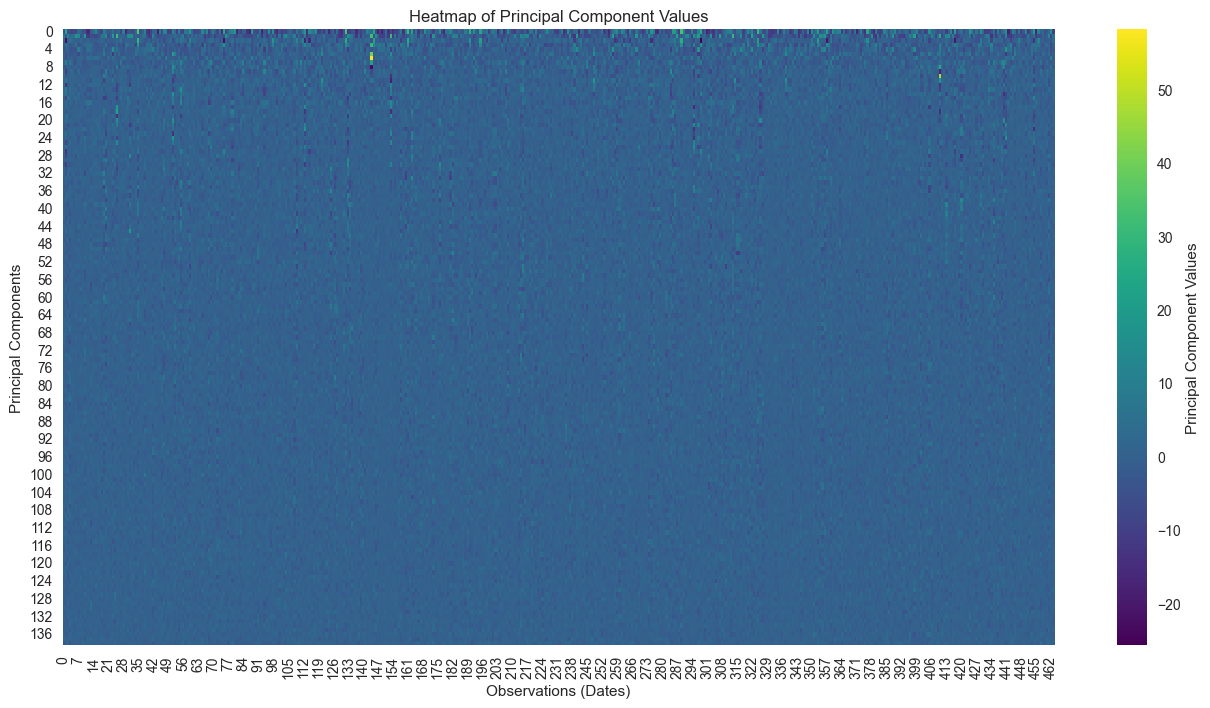

In [9]:
# Create a heatmap to visualize the values of principal components
plt.figure(figsize=(16, 8))
sns.heatmap(principal_components.T, cmap='viridis', cbar_kws={'label': 'Principal Component Values'})
plt.title('Heatmap of Principal Component Values')
plt.xlabel('Observations (Dates)')
plt.ylabel('Principal Components')
plt.show()

#### KMeans
Another way is to use KMeans clustering algorithm to cluster

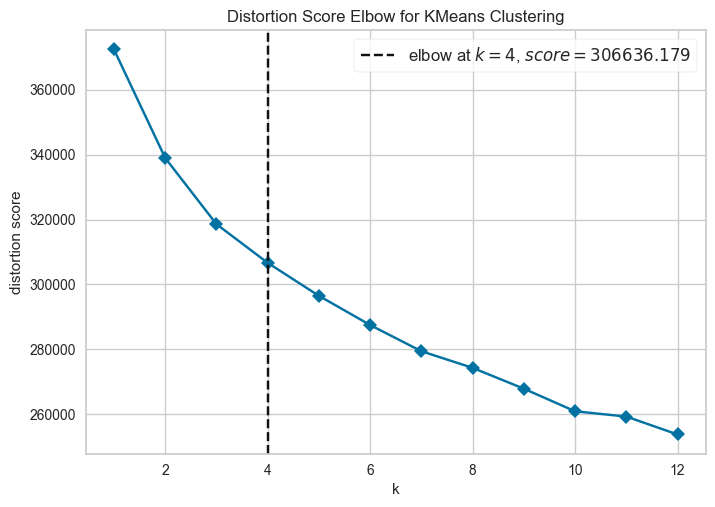

AbbVie
Abbott
Accenture
Archer-Daniels-Midland
Automated Data Processing
Aflac
Assurant
Arthur J. Gallagher & Co.
Allstate
Allegion
Amcor
Ametek
Amgen
Aon
A. O. Smith
Air Products and Chemicals
Amphenol
Avery Dennison
AutoZone
Baxter International
Best Buy
Becton Dickinson
Biogen
Booking Holdings
BlackRock
Bristol Myers Squibb
Broadridge Financial Solutions
Brown & Brown
Boston Scientific
Cardinal Health
Chubb Limited
CBRE Group
CDW
CH Robinson
Charter Communications
Cigna
Cincinnati Financial
Comcast
CME Group
Cummins
Centene Corporation
CooperCompanies
Costco
Copart
Cisco
CSX
Cintas
Cognizant
CVS Health
John Deere
Dollar General
Quest Diagnostics
DR Horton
Danaher Corporation
Walt Disney
Dollar Tree
Dover Corporation
Domino's
Darden Restaurants
DaVita Inc.
Ecolab
Equifax
Estée Lauder Companies (The)
Elevance Health
Emerson Electric
Eaton Corporation
Expeditors International
Fastenal
FactSet
FedEx
F5, Inc.
Fidelity National Information Services
Fleetcor
FMC Corporation
Fortive
General

In [10]:
# Create k-Means model and find optimal number of clusters with the elbow method
model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(
    model, k=(1,13), timings=False, random_state = 1
)

visualizer.fit(principal_components)        
visualizer.show()
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, random_state=1)
cluster_assignments = kmeans.fit_predict(principal_components)

# Add the cluster assignments to a copy of the returns dataframe
returns_clustered = ret_T.copy()
returns_clustered['Cluster'] = cluster_assignments

# Explore Clusters
# Explore the clusters to identify potential pairs
for cluster_id in range(n_clusters):
    cluster_stocks = returns_clustered[returns_clustered['Cluster'] == cluster_id].drop(columns=['Cluster'])
    mean_returns = cluster_stocks.mean(axis=1)
    for name, value in mean_returns.items():
        print(companies_dict[name])

print(n_clusters)

Print out the clkusters ticker and company is said cluster

In [11]:
# Create and fit the model with the optimal number of clusters from above
model = KMeans(n_clusters = n_clusters)
model.fit(ret_T)

labels = model.predict(ret_T)

# Create a DataFrame aligning labels & companies
clusters = pd.DataFrame({'cluster': labels, 'ticker': returns_1_day.columns})

for i in clusters.index:
    clusters.loc[i,"company"] = companies_dict[clusters.loc[i,"ticker"]]

# Display df sorted by cluster labels
clusters.sort_values('cluster').reset_index(drop=True)

clusters.groupby("cluster").count()


,ticker,company
cluster,,
0,154,154
1,83,83
2,207,207
3,20,20


#### DBSCAN
We see the problem with KMeans clustering. It will always find clusters, even if the data doesn't have any clusters. In this case, we see that the clusters are not very meaningful. We can see that some of the stocks in each cluster are not very similar to each other. 

In [12]:
eps_value = 15
min_samples_value = 5

clf = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clf.fit(principal_components)

# Extract cluster labels and remove noise points
labels = clf.labels_
clustered_mask = (labels != -1)
# print(clustered_mask)
clustered_data = principal_components[clustered_mask]
clustered_labels = labels[clustered_mask]

# Calculate the number of clusters (excluding noise)
n_clusters_ = len(set(clustered_labels))
# Calculate the number of noise points
n_noise_ = len(labels) - len(clustered_data)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Calculate silhouette score for clustered data
silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)
print(f"Silhouette Coefficient (excluding noise): {silhouette_avg:.3f}")

Estimated number of clusters: 3
Estimated number of noise points: 333
Silhouette Coefficient (excluding noise): 0.216


Silhouette Coefficient is already quite good but lets try to improve it by tuning the hyperparameters!

In [13]:

eps_values = np.arange(5, 30, 0.1)
min_samples_values = list(range(3, 10))  # We want to test min_samples values starting 2

best_eps = None
best_min_samples = None
best_silhouette_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clf.fit_predict(principal_components)
        unique_labels = set(labels)

        if len(unique_labels) <= 4 or len([label for label in labels if label != -1]) <= 120:  # We want at least 4 clusters
            pass
        else:
            clustered_mask = (labels != -1)
            clustered_data = principal_components[clustered_mask]
            clustered_labels = labels[clustered_mask]

            # Calculate silhouette score
            silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)

            # Update best parameters if silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")

# Fit DBSCAN with best parameters
best_clf = DBSCAN(eps=best_eps, min_samples=best_min_samples)

best_labels = best_clf.fit_predict(principal_components)
n_clusters_ = len(set(best_labels)) - (1 if -1 in best_labels else 0)

# This is used to make it unifrom with the previous code (I'll make it more unform later when we submit the code)
clustered = best_clf.labels_


best_clustered_mask = (best_labels != -1)
best_clustered_data = principal_components[best_clustered_mask]
best_clustered_labels = best_labels[best_clustered_mask]

n_noise_ = list(best_labels).count(-1)

clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {best_silhouette_score:.3f}")


Best eps: 13.29999999999997
Best min_samples: 3
Best Silhouette Score: 0.3324422717886806
Estimated number of clusters: 17
Estimated number of noise points: 337
Silhouette Coefficient: 0.332


Let us visualize the clusters we just created

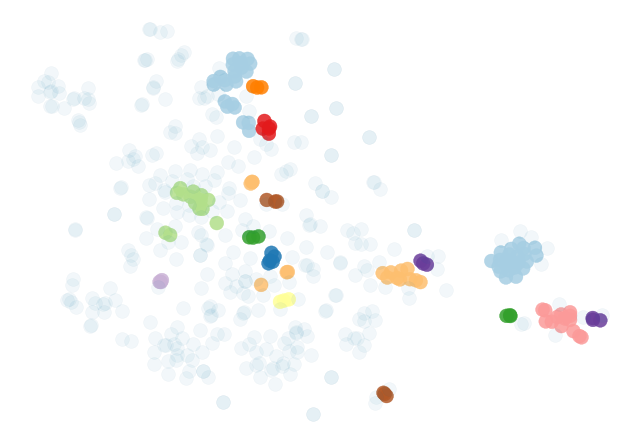

In [14]:
plt.figure(1, facecolor='white')
plt.clf()
tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1)
tsne_result = tsne.fit_transform(principal_components)

plt.scatter(
    tsne_result[(clustered!=-1), 0],
    tsne_result[(clustered!=-1), 1],
    s=100,
    alpha=0.85,
    c=clustered[clustered!=-1],
    cmap=cm.Paired
)

plt.scatter(
    tsne_result[(clustered_series_all==-1).values, 0],
    tsne_result[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

#plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.axis("off")
plt.savefig('DBSCAN_cluster.svg',format='svg', bbox_inches='tight')
plt.show()

# print(tsne_result)


And also print out the names of the clusters

In [15]:
DBSCAN_cluster =[]
# print out the stock names that are in each cluster
for i in range(len(ticker_count_reduced)):
    print("Cluster " + str(i+1) + " (" + str(len(clustered_series[clustered_series==i])) + " stocks)")
    for name in clustered_series[clustered_series==i].index:
        print(companies_dict[name], end=", ")
        DBSCAN_cluster.append({"Cluster": i,"Stock":name,"Stock_Name":companies_dict[name]})
    print("\n")
    # print(clustered_series[clustered_series==i].index.tolist())
    # print(", ".join(clustered_series[clustered_series==i].index.tolist()))
    # print()


Cluster 1 (23 stocks)
Ameren, American Electric Power, Atmos Energy, American Water Works, CMS Energy, Dominion Energy, DTE Energy, Duke Energy, Consolidated Edison, Eversource, Entergy, Evergy, Exelon, Alliant Energy, NextEra Energy, NiSource, Public Service Enterprise Group, Pinnacle West, PPL Corporation, Southern Company, Sempra Energy, WEC Energy Group, Xcel Energy, 

Cluster 2 (23 stocks)
Aflac, Ameriprise Financial, Bank of America, Citigroup, Citizens Financial Group, Comerica, Fifth Third Bank, Globe Life, Goldman Sachs, Huntington Bancshares, JPMorgan Chase, KeyCorp, Loews Corporation, MetLife, Morgan Stanley, M&T Bank, Principal Financial Group, PNC Financial Services, Prudential Financial, Regions Financial Corporation, Truist, U.S. Bank, Zions Bancorporation, 

Cluster 3 (5 stocks)
Arthur J. Gallagher & Co., Aon, Brown & Brown, Marsh McLennan, Willis Towers Watson, 

Cluster 4 (14 stocks)
Ametek, Amphenol, Dover Corporation, Emerson Electric, Eaton Corporation, Fortive, Ho

## Pair Selection

Init pair selection parameters

In [16]:
# Minimum correlation
min_corr = 0.9

# Max p-value to dismiss the h0-hypothesis in the cointegration test
pmax_coint = 0.05

# Max p-value to dismiss the h0-hypothesis in the augmented Dickey-Fuller test
pmax_adf = 0.05

# Max number of stock pairs to consider in the portfolio
max_quantity_pairs = 20

# Consider cluster from DBSCAN and consider train data for the pair selection
selected_clusters = pd.DataFrame(DBSCAN_cluster.copy())
train_data = data.copy()

# Filter the DataFrame based on the tickers in the specified cluster
selected_data = train_data[selected_clusters["Stock"]]

### Pair Validation
We check the identified clusters for stock pairs. In order to be considered as a pair, the following hypothese have to be met:   
    1. Correlation of stock price evolution of 95% or higher (and different to 1)  
    2. Check if the Cointegration hypothesis ho is dismissed  
    3. Check if the Augmented Dickey-Fuller hypothesis ho is dismissed 

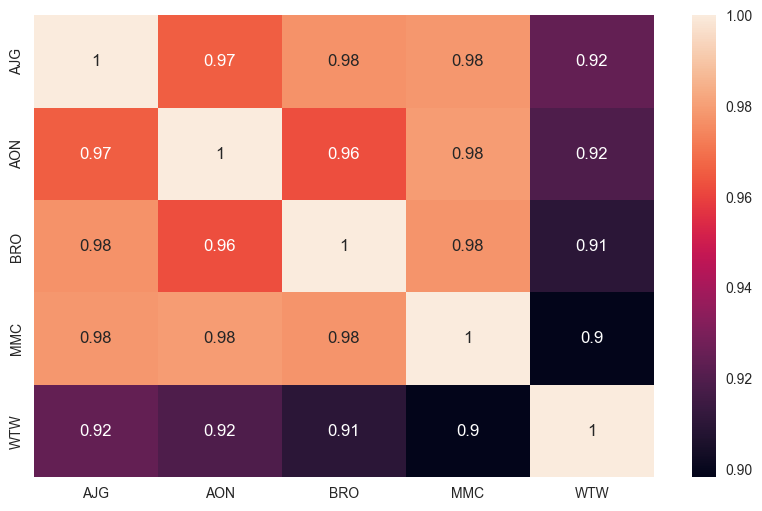

In [17]:
# Correlation test for the remaining stocks
corr = selected_data.corr()

# We investigate the correlation within a single cluster
cluster_to_investigate =2
cluster_stocks= selected_clusters[selected_clusters["Cluster"]==cluster_to_investigate]
plt.figure(figsize=(10, 6))
sns.heatmap(selected_data[cluster_stocks["Stock"]].corr(), annot=True)
plt.savefig(f'Correlation_Cluster_{cluster_to_investigate}.png',format='png', bbox_inches='tight')
plt.show()


#We also want to create a table giving us the KPIs of each pair
cluster_oversight =set()
for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == cluster_to_investigate, "Stock"], 2):
        stock1, stock2 = pair
        # Correlation
        correlation = corr[stock1][stock2]
        #Cointegration
        coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        # Augmented Dickey-Fuller Test
        first_ADF = adfuller(selected_data[stock1])                             # Stationarity of stock 1
        second_ADF = adfuller(selected_data[stock2])                            # Stationarity of stock 2
        Spread_ADF = adfuller(selected_data[stock1] - selected_data[stock2])    # Stationarity of the spread between stock 1 and 2
        Ratio_ADF = adfuller(selected_data[stock1] / selected_data[stock2])     # Stationarity of the ratio of stock 1 and 2
        
        # We save the correlation as well as the p-values of the cointegration and the ADF
        cluster_oversight.add((stock1, stock2, correlation,coint[1],first_ADF[1],second_ADF[1],Spread_ADF[1],Ratio_ADF[1]))

cluster_oversight = pd.DataFrame(cluster_oversight, columns=["Stock 1","Stock 2","Correlation","Cointegration","ADF Stock 1","ADF Stock 2","ADF Spread","ADF Ratio"])
cluster_oversight.to_excel("ClusterOversight.xlsx", index = False)

In [ ]:
# Now we apply our heuristics all clusters to identify all potential stock pairings
eligible_pairs_list = set()

for cluster in selected_clusters["Cluster"].unique():
    for pair in combinations(selected_clusters.loc[selected_clusters["Cluster"] == cluster, "Stock"], 2):
        # Find pair 
        stock1, stock2 = pair

        # Determine correlation value
        correlation = corr[stock1][stock2]
        
        # Check if Correlation is significant
        # Note: Dismiss correlation equal to 1 since this is realisticly only possible between the same stock
        if correlation > min_corr and correlation != 1:
            coint = sm.tsa.coint(selected_data[stock1], selected_data[stock2])
        
            # Check if the cointegration test is significant
            if coint[1] <= pmax_coint:

                # Augmented Dickey-Fuller Test
                first_ADF = adfuller(selected_data[stock1])                             # Stationarity of stock 1
                second_ADF = adfuller(selected_data[stock2])                            # Stationarity of stock 2
                Spread_ADF = adfuller(selected_data[stock1] - selected_data[stock2])    # Stationarity of the spread between stock 1 and 2
                Ratio_ADF = adfuller(selected_data[stock1] / selected_data[stock2])     # Stationarity of the ratio of stock 1 and 2

                # In the end we consider the ratio for our strategy, therefore we take the corresponding ADF test into account
                if Ratio_ADF[1] <= pmax_adf:
                    # Add pair to list
                    eligible_pairs_list.add((stock1, stock2, correlation,coint[1],Ratio_ADF[1]))

### Ranking potential pairs
We try to rank the remaining pairs now by the chance, that they are eligible for the pairs trading hypothesis. In order to make this ranking we consider following weight function:

$ Chance_{eligible} = (1-p_{coint}) *(1-p_{ADF})$

In [ ]:
# Sort identified pairs by their test results
sorted_eligible_pairs = sorted(eligible_pairs_list, key=lambda x: (1-x[3])*(1-x[4]), reverse=True)

# Create a DataFrame to store informations
sorted_eligible_pairs_df = pd.DataFrame(sorted_eligible_pairs, columns=['Stock_1', 'Stock_2', 'Correlation', 'Cointegration','Ratio_ADF'])

# In case of too many pairs we select n pairs to our convenience
selected_pairs = sorted_eligible_pairs[:max_quantity_pairs]

# Print the selected pairs
print("\nA total of "+str(len(sorted_eligible_pairs))+" pairs have been found.")
print(f"A total of {len(selected_pairs)} were selected.")
sorted_eligible_pairs_df[:max_quantity_pairs]


### Pair Visualization
We reeintroduce the visualization through TSNE in order to inspect the chosen pairs.  
Note that the visualization in 2D thorugh TSNE might not reflect the conclusion that DBSCAN or the hypothesis tests  have made before

In [ ]:
#Build DataFrame which collects all TSNE results from concerned stocks
tsne_selected = []
for x,y in ([row[0],row[1]] for row in selected_pairs):
    tsne_selected.append([x,tsne_result[ret_T.index.get_loc(x),0],tsne_result[ret_T.index.get_loc(x),1]])
    tsne_selected.append([y,tsne_result[ret_T.index.get_loc(y),0],tsne_result[ret_T.index.get_loc(y),1]])

# Convert the list to a set to get unique elements based on the first element of each sub-list
tsne_selected = {tuple(row) for row in tsne_selected}
tsne_selected = list(tsne_selected)
tsne_selected = pd.DataFrame(tsne_selected, columns =["Stock","x","y"])


# Define a color map
color_map = cm.get_cmap('tab20')

# Connect datapoints with lines based on top_10_pairs
for index,pair in enumerate(selected_pairs):
    x1, y1 = tsne_selected.loc[tsne_selected["Stock"] == pair[0], ["x", "y"]].values.flatten()
    x2, y2 = tsne_selected.loc[tsne_selected["Stock"] == pair[1], ["x", "y"]].values.flatten()

    color = color_map(index / len(selected_pairs))
    plt.scatter(x1, y1, s=100, alpha=0.85, label="Stocks", color=color)
    plt.scatter(x2, y2, s=100, alpha=0.85, label="Stocks", color=color)
    plt.plot([x1, x2], [y1, y2], color="grey", linestyle='--', linewidth=1)

# Annotate each point with its label
for index, row in tsne_selected.iterrows():
    plt.annotate(row["Stock"], (row["x"], row["y"]+1), textcoords="offset points", xytext=(5,5), ha='right')

# Customize the plot as needed
plt.title('Selected Pairs on TSNE Visualization')
plt.axis("off")

# Show the plot
plt.show()
